<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L34-GraphClassificationGraphIsomorphismNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Classification

Implementaremos un nuevo GNN en el conjunto de datos PROTEINS , que comprende 1113 gráficos que representan proteínas. Compararemos diferentes métodos para la clasificación de gráficos y analizaremos nuestros resultados.

## Expresividad

Con GNN, nuestro objetivo es producir las mejores embeddings de nodos posibles. Esto significa que diferentes nodos deben tener embedding diferentes y nodos similares deben tener embedding similares. Pero ¿cómo sabemos que dos nodos son similares? Las embedding se calculan utilizando conexiones y características de nodos. Por lo tanto, tenemos que comparar sus características y vecinos para distinguir los nodos.

En teoría de grafos, esto se conoce comocomo el problema de isomorfismo gráfico . Dos grafos son isomórficos (“iguales”) si tienen las mismas conexiones y su única diferencia es una permutación de sus nodos. [En 1968, Weisfeiler y Lehman](https://www.iti.zcu.cz/wl2018/pdf/wl_paper_translation.pdf) propusieron un algoritmo eficiente para resolver este problema, ahora conocido como **Test WL**.

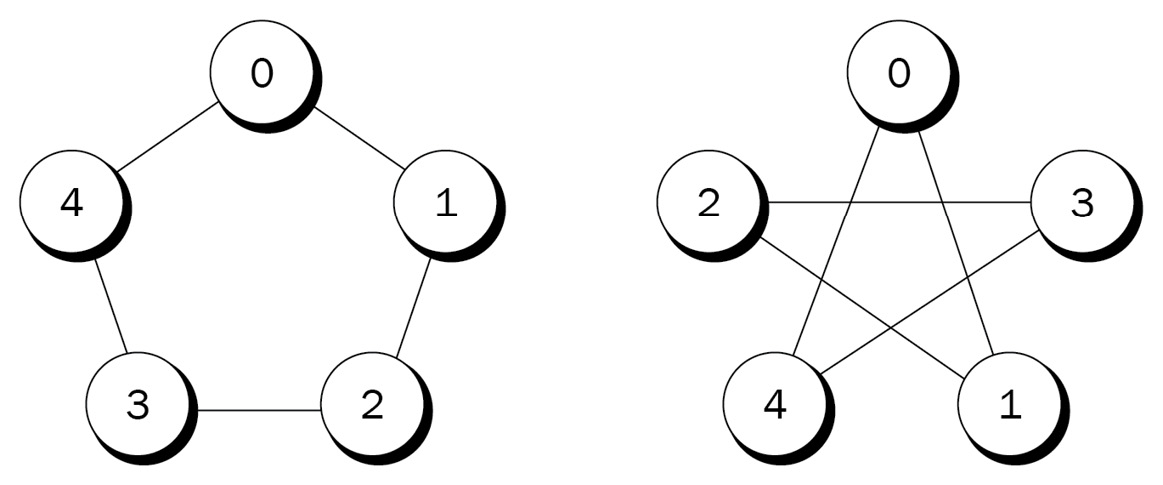

La prueba WLtiene como objetivo construirla **forma canónica** de un gráfico. Luego podemos comparar la forma canónica de dos gráficas para comprobar si son isomorfas o no. Sin embargo, esta prueba no es perfecta y los gráficos no isomorfos pueden compartir la misma forma canónica. Esto puede resultar sorprendente, pero es un problema complejo que aún no se comprende del todo; por ejemplo, se desconoce la complejidad del algoritmo WL.

La prueba WL funciona como sigue:

1. Al principio, cada nodo del gráfico recibe el mismo color.
2. Cada nodo agrega su propio color y los colores de sus vecinos.
3. El resultado se envía a una función hash que produce un nuevo color.
4. Cada nodo agrega su nuevo color y los nuevos colores de sus vecinos.
5. El resultado se envía a una función hash que produce un nuevo color.
6. Estos pasos se repiten hasta que ya no cambien de color más nodos.

La siguiente figura resume el algoritmo WL:

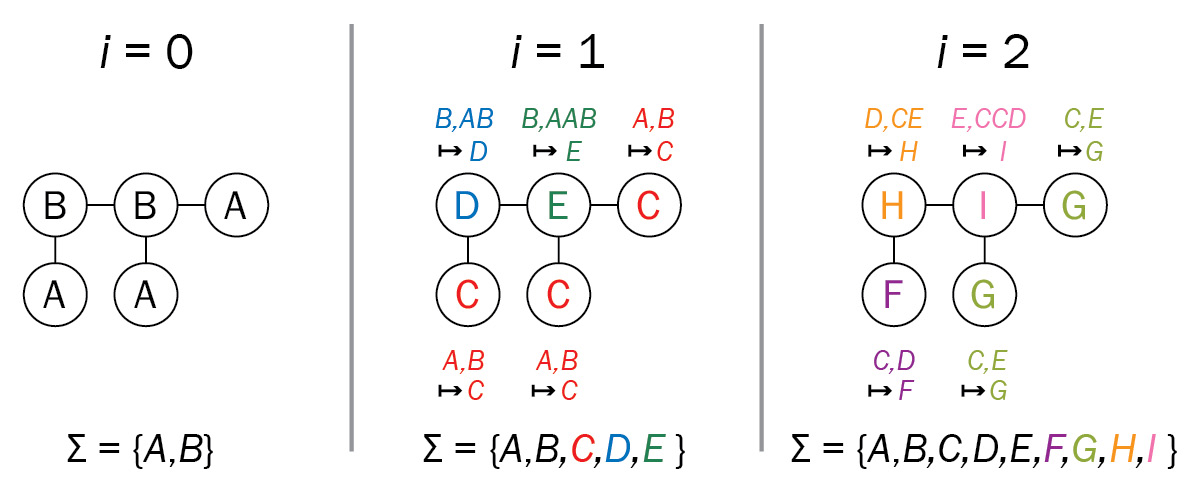

Los colores resultantes nos dan la forma canónica del gráfico. Si dos gráficas no comparten los mismos colores, no son isomorfas. Por el contrario, no podemos estar seguros de que sean isomórficos si obtienen los mismos colores.

Los pasos que describimos deberían resultarle familiares; están sorprendentemente cerca de lo que realizan los GNN. Los colores son una forma de embeddings y la función hash es un agregador.

De hecho, el agregador de suma puede discriminar más estructuras de grafos que agregar por máximo o agregar por medio. Si seguimos esta lógica, esto sólo puede significar una cosa: los agregadores que hemos estado usando hasta ahora no son óptimos, ya que son estrictamente menos expresivos que una suma. ¿Podemos utilizar este conocimiento para construir mejores GNN? Presentamos la **Graph Isomorphism Network (GIN)** basada en esta idea.


## Intro to Graph Isomorphism Network (GIN)

Dado que la capacidad de distinguir más estructuras de grafos parece estar relacionada con la calidad de las embedding resultantes, se introduce el GIN.

Introducido en [2018 por Xu et al. en un artículo titulado “¿Qué tan poderosas son las redes neuronales gráficas?”](https://cs.stanford.edu/people/jure/pubs/gin-iclr19.pdf), el GIN está diseñado para ser tan expresivo como la prueba WL. Los autores generalizaron nuestras observaciones sobre la agregación dividiéndola en dos funciones:

- Aggregate: función $f$ que selecciona los nodos veinos que la GNN considera.
- Combine: función $Φ$ combina los embeddings de los nosods seleccionados para producri un nuevo embedding del nodo destino.

el embedding del $i-ésimo$ nodo se puede escribir de la siguiente manera:

$$
h_i^{'}=Φ (h_i, f(\{h_j:j \in N_i\}))
$$

Como se evidencia la función $f$ agrega todos los vecinos del $i$ nodo y $Φ$ aplica un agregador medio especifico. Entonces, ¿cuáles son estas funciones en el GIN? Xu et al. argumentan que ellos tiene que ser inyectivo. Las funciones inyectivas asignan distintas entradas a distintas salidas.

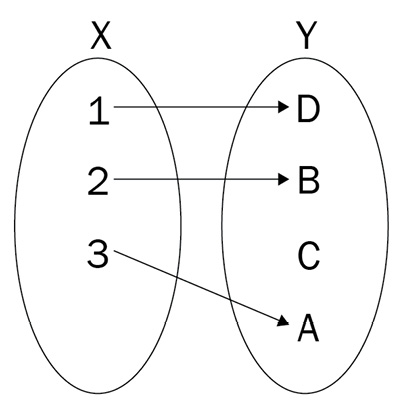

Esto es precisamente lo que queremos distinguir entre las estructuras gráficas. Si las funciones no fueran inyectivas, terminaríamos con la misma salida para diferentes entradas. En este caso, nuestras embeddings serían menos valiosas porque contendrían menos información.

## Graph Classification with GIN

Se podría implementar directamente un modelo GIN para la clasificación de nodos, pero esta arquitectura es más interesante para realizar la clasificación de grafos. En esta sección, veremos cómo transformar embeddings de nodos en embeddings de gráficos utilizando técnicas de agrupación global.

Luego aplicaremos estas técnicas al conjunto de datos de `PROTEINS` y compararemos nuestros resultados utilizando los modelos **GIN** y **GCN**.

### Graph classification

Clasificación de grafos se basa en las embeddings de nodos que produce un **GNN**. Esta operación a menudo se denomina agrupación global o lectura a nivel de grafo. Hay tres formas sencillas de implementarlo:

- Agrupación Global Media (Mean global pooling):
  El embeddings del grafo $h_G$ se obtiene al promediar el embedding de cada nodo en el grafo.

  $$
  h_G = \frac{1}{N}\sum_{i=0}^Nh_i
  $$

- Agrupación gloabl máxima (Max global pooling):
  El embedding del grafo se obtiene por seleccionar el valor más alto de cada nodo en el grafo.

  $$
  h_G=max_{i=0}^N(h_i)
  $$

- Suma de agrupación global(Sum gloabl pooling):
  El embedding del grafo se obtiene por la suma de los embeddings de cada nodo en el grafo.

  $$
  h_G=\sum_{i=0}^Nh_i
  $$


la agrupación global por suma es estrictamente más expresiva que las otras dos técnicas. Los autores de GIN también señalan que para considerar toda la información estructural, es necesario considerar las embeddings producidas por cada capa de GNN. En resumen, concatenamos la suma de embeddings de nodos producidas por cada una de las k capas de nuestro GNN:

$$
h_g=\sum_{i=0}^N h_i^0 || ... || \sum_{i=0}^N h_i^k
$$

Esta solución combina elegantemente el poder expresivo del operador de suma con la memoria de cada capa proporcionada por la concatenación.


## Implementing the GIN

Ahora implementaremos un modelo **GIN** con la función de clasificación de grafos basado en el conjunto de datos `PROTEINS [5, 6, 7] `.

Este conjunto de datos comprende 1113 gráficos que representan proteínas, donde cada nodo es un aminoácido. Un borde conecta dos nodos cuando su distancia es inferior a 0,6 nanómetros. El objetivo de este conjunto de datos es clasificar cada proteína como una enzima. Las enzimas son un particular tipo de proteína que actúa como catalizador para acelerar las reacciones químicas en una célula.

Por ejemplo, las enzimas llamadas lipasas ayudan en la digestión de los alimentos.

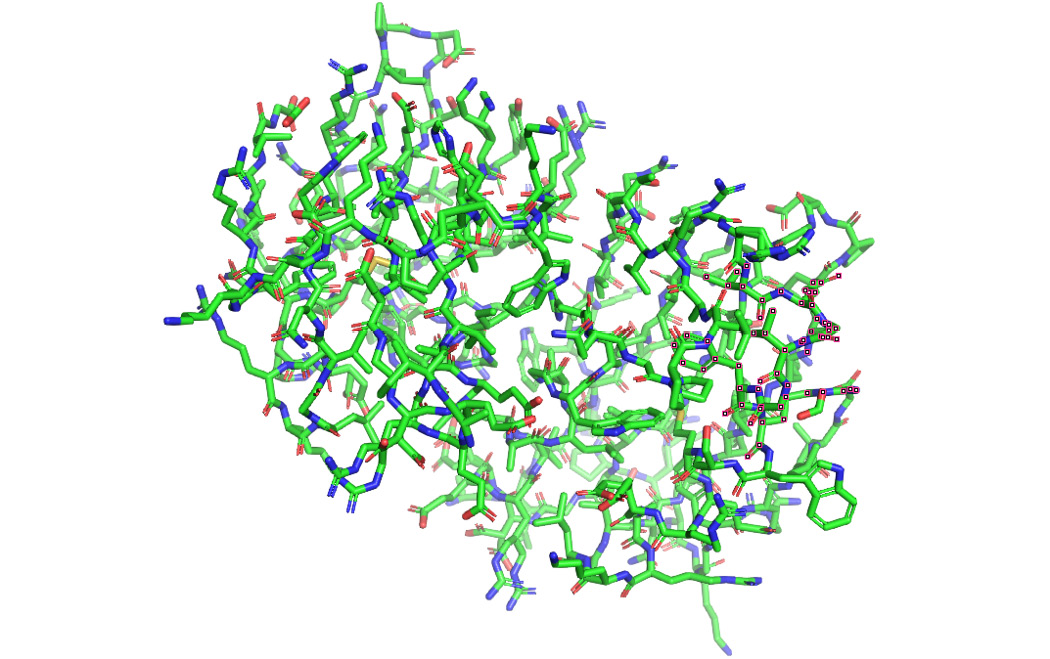

In [1]:
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install pyg_lib --no-index -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 51.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 32.4 MB/s eta 0:00:00


In [2]:
import torch
# !pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(11)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import torch
torch.manual_seed(0)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

Primero, importamos el conjunto de datos PROTEINS usando la clase TUDataset de PyTorch Geométrico e imprimimos la información

In [4]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: PROTEINS(1113)
-----------------------
Number of graphs: 1113
Number of nodes: 31
Number of features: 3
Number of classes: 2


Done!


Dividimos los datos (grafos) en conjuntos de entrenamiento, validación y prueba con una división 80/10/10 respectivamente

In [5]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs


Conviertimos estas divisiones en mini lotes usando el objeto `DataLoader` con un tamaño de lote de 64. Esto significa que cada lote contendrá hasta 64 grafos

In [6]:
# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Let's check it!
print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')


Train loader:
 - Batch 0: DataBatch(edge_index=[2, 8842], x=[2326, 3], y=[64], batch=[2326], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 8882], x=[2401, 3], y=[64], batch=[2401], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 6838], x=[1820, 3], y=[64], batch=[1820], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 7344], x=[1982, 3], y=[64], batch=[1982], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 9348], x=[2455, 3], y=[64], batch=[2455], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 7620], x=[2076, 3], y=[64], batch=[2076], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 12274], x=[3157, 3], y=[64], batch=[3157], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 8206], x=[2216, 3], y=[64], batch=[2216], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 10436], x=[2768, 3], y=[64], batch=[2768], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 9060], x=[2486, 3], y=[64], batch=[2486], ptr=[65])
 - Batch 10: DataBatch(edge_index=[2, 9344], x=[2570, 3], y=[64], batch=[2570], ptr=[65])
 - 

Empecemos, la implementación de un modelo GIN. La primera pregunta que tenemos que responder es la composición de nuestra capa GIN.

Necesitamos un MLP con al menos dos capas. Siguiendo las pautas de los autores, también podemos introducir la normalización por lotes para estandarizar las entradas de cada capa oculta, lo que estabiliza y acelera el entrenamiento. En resumen, nuestra capa GIN tiene la siguiente composición:

$$
Linear ⟶ BatchNorm ⟶ ReLU ⟶ Linear ⟶ RelU
$$

In [7]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3) # Capa de almacenamiento
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

PyTorch Geométrico también ofrece la capa GIN, una versión modificada de la capa GIN. Fue introducido en [2020 por Hu et al. en "Strategies for Pre-training Graph Neural Networks"](https://arxiv.org/pdf/1905.12265.pdf).

Su principal mejora con respecto a la versión anterior de GIN es la capacidad de considerar características de vanguardia durante el proceso de agregación. El conjunto de datos PROTEINS no tiene edge features o atruibutos, por lo que implementaremos el modelo GIN clásico.

```python
GIN.lin1 = Linear(GIN.dim_h*3, GIN.dim_h*3)
GIN.lin2 = Linear(GIN.dim_h*3, dataset.num_classes)
```

No debemos olvidar que queremos realizar una clasificación de gráficos. Requiere la suma de cada nodo incrustado en el gráfico para cada capa. En otras palabras, necesitaremos almacenar un vector de tamaño dim_h por capa (tres, en este ejemplo). Es por eso que agregamos una capa lineal con un tamaño de 3*dim_h antes de la capa lineal final para la clasificación binaria ( data.num_classes = 2)

In [8]:
def forward(self, x, edge_index, batch):
    # Node embeddings
    h1 = self.conv1(x, edge_index)
    h2 = self.conv2(h1, edge_index)
    h3 = self.conv3(h2, edge_index)

    # Graph-level readout
    h1 = global_add_pool(h1, batch)
    h2 = global_add_pool(h2, batch)
    h3 = global_add_pool(h3, batch)

    # Concatenate graph embeddings
    h = torch.cat((h1, h2, h3), dim=1)

    # Classifier
    h = self.lin1(h)
    h = h.relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.lin2(h)

    return F.log_softmax(h, dim=1)

GIN.forward = forward

Debemos implementar la lógica para conectar nuestras capas inicializadas. Cada capa produce un tensor de embedding diferente: h1, h2 y h3 . Los sumamos usando la función `global_add_pool()` y luego los concatenamos con `torch.cat()`. Esto nos da la entrada a nuestro clasificador, que actúa como una red neuronal normal con una capa de abandono.

Ahora, podemos implementar el ciclo de entrenamiento regular por mini lotes durante 100 épocas.

In [9]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward() # Computa los gradientes
            optimizer.step() # Actualiza los pesos

            # Validation
            val_loss, val_acc = test(model, val_loader)

        # Print train and validation metrics every 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    return model

La función de prueba debe incluir mini lotes, ya que nuestros `DataLoader` de validación y prueba contienen más de un lote...

In [10]:
@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

Ahora definimos la función para calcular la precisión

In [11]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

Instanciamos y entrenamos nuestro modelo GIN

In [12]:
gin = GIN(dim_h=32)
gin = train(gin, train_loader)

Epoch   0 | Train Loss: 0.95 | Train Acc: 61.08% | Val Loss: 0.56 | Val Acc: 63.45%
Epoch  20 | Train Loss: 0.53 | Train Acc: 73.42% | Val Loss: 0.44 | Val Acc: 80.77%
Epoch  40 | Train Loss: 0.51 | Train Acc: 75.98% | Val Loss: 0.48 | Val Acc: 77.86%
Epoch  60 | Train Loss: 0.48 | Train Acc: 75.74% | Val Loss: 0.45 | Val Acc: 81.83%
Epoch  80 | Train Loss: 0.49 | Train Acc: 75.70% | Val Loss: 0.45 | Val Acc: 80.27%
Epoch 100 | Train Loss: 0.49 | Train Acc: 77.12% | Val Loss: 0.45 | Val Acc: 81.33%


Finalmente, vamos a probarlo con el loader en dataset de test

In [13]:
test_loss, test_acc = test(gin, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.50 | Test Acc: 76.82%


Ahora crearemos un **CGN** para comparar los resultados del modelo

In [14]:
class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)

        return F.log_softmax(h, dim=1)

Iniciamos y entrenamos el modelo **CGN**

In [15]:
gcn = GCN(dim_h=32)
gcn = train(gcn, train_loader)

Epoch   0 | Train Loss: 0.67 | Train Acc: 58.92% | Val Loss: 0.66 | Val Acc: 65.29%
Epoch  20 | Train Loss: 0.61 | Train Acc: 68.93% | Val Loss: 0.58 | Val Acc: 67.49%
Epoch  40 | Train Loss: 0.60 | Train Acc: 70.10% | Val Loss: 0.57 | Val Acc: 75.45%
Epoch  60 | Train Loss: 0.60 | Train Acc: 72.33% | Val Loss: 0.56 | Val Acc: 74.73%
Epoch  80 | Train Loss: 0.60 | Train Acc: 71.12% | Val Loss: 0.55 | Val Acc: 74.52%
Epoch 100 | Train Loss: 0.60 | Train Acc: 69.80% | Val Loss: 0.55 | Val Acc: 75.02%


Ahora, finalmente lo testeamos con el loader de test

In [16]:
test_loss, test_acc = test(gcn, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
print()

Test Loss: 0.60 | Test Acc: 74.74%



Para comprender mejor la puntuación de esta prueba final, podemos implementar un **GCN** que realice una clasificación de grafos con una agrupación de medias global simple (`global_mean_pool()` en PyTorch Geométrico). Con exactamente la misma configuración, logra una puntuación de precisión promedio del 53,72 % (± 0,73 %) en 100 experimentos. Esto es muy inferior al promedio de 76,56% (± 1,77%) obtenido por el modelo **GIN**.

Podemos concluir que toda la arquitectura **GIN** es mucho más adecuada para esta tarea de clasificación de gráficos que los **GCN**. Según el marco teórico que utilizamos, esto se explica por el hecho de que los GCN son estrictamente menos expresivos que los **GIN**. En otras palabras, los GIN pueden distinguir más estructuras gráficas que los **GCN**, por lo que son más precisos. Podemos verificar esta suposición visualizando los errores cometidos por ambos modelos.

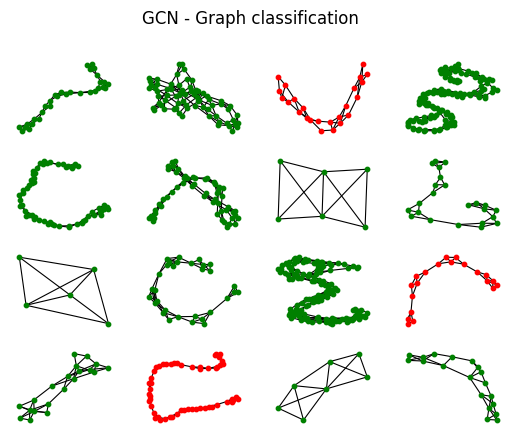

In [17]:
fig, ax = plt.subplots(4, 4)#, figsize=(12, 9))
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

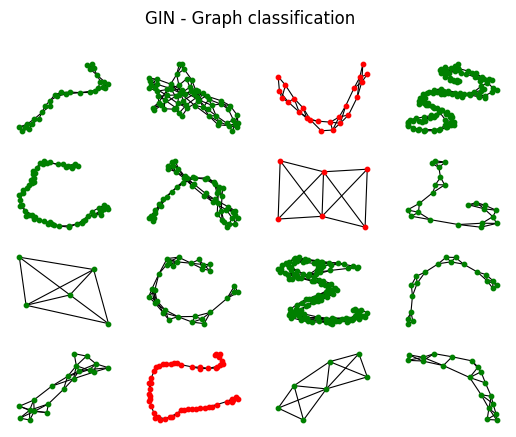

In [18]:
fig, ax = plt.subplots(4, 4)
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

Como era de esperar, el modelo **GCN** comete más errores. Comprender que estructuras de grafos no se capturan adecuadamente requeriría un análisis exhaustivo de cada proteína clasificada correctamente por **GIN**. Sin embargo, podemos ver que el GIN también comete diferentes errores. Esto es interesante porque muestra que estos modelos pueden ser complementarios.

Crear ensambles a partir de modelos que cometen diferentes errores es una técnica común en el aprendizaje automático. Podríamos utilizar diferentes enfoques, como un tercer modelo entrenado en nuestras clasificaciones finales. Implementaremos una técnica simple de promedio de modelos

Primero, configuramos los modelos en modo de evaluación y definimos las variables para almacenar puntuaciones de precisión

In [19]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc_ens = 0

Nosotrosobtenga las clasificaciones finales para cada modelo y combínelas para obtener las predicciones del conjunto

Calculamos las puntuaciones de precisión para los tres conjuntos de predicciones

In [20]:
for data in test_loader:
    # Get classifications
    out_gcn = gcn(data.x, data.edge_index, data.batch)
    out_gin = gin(data.x, data.edge_index, data.batch)
    out_ens = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)

Finalmente, imprimamos los resultados

In [21]:
# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc_ens*100:.2f}%')

GCN accuracy:     73.96%
GIN accuracy:     75.52%
GCN+GIN accuracy: 72.92%


En estoPor ejemplo, nuestro conjunto supera a ambos modelos con una puntuación de precisión del 81,25 % (en comparación con el 72,14 % del GCN y el 80,99 % del GIN). Este resultado es significativo, ya que muestra las posibilidades que ofrece este tipo de técnica.

Sin embargo, este no es necesariamente el caso en general; Incluso con este ejemplo, el modelo de conjunto no supera consistentemente al GIN. Podríamos enriquecerlo con incrustaciones de otras arquitecturas, como Node2Vec , y ver si mejora la precisión final.